# IBM Capstone Project 
## Investigatin EV Charger locations in London

Electric Vehicles, (EVs) are seen as an environmentally friendly alternative to petrol vehicles. Electric vehicles (plug in) do not require fossil fuels, leading to reduced total fuel consumption, and do not emit greenhouse gas emissions. As the United Kingdom strives to meet its net zero carbon target and reduce its dependence on fossil fuels the electrification of transport is becoming increasingly important. There has been, in recent years, a rapid growth in the amount of EVs in both residential and public transport. EVs require supportive infrastructure in the form of charging stations. Residential charging stations refer to chargers located on an owner’s private property that is used by the owner alone. Public chargers are available in public areas like sidewalks or public parking garages. These public chargers are the equivalent of petrol fuelling stations and will be required to recharge EVs during normal daily activities especially for commuters or public transport who may require re-charging as the day progresses. There are two broad types of chargers; rapid chargers and regular or slow chargers. As the name implies rapid chargers may charge vehicles in minutes to hours while regular chargers may require a few hours to possibly overnight charging. Ensuring the optimal type, location and number of chargers installed in extremely important especially in a densely populated city like London. As its workday population is significantly high during the day rapid chargers may need to be located in areas with more public parking. While regular chargers may be more suited to more residential areas. This project will therefore seek to investigate the locations of these chargers in London boroughs to determine how they are currently distributed and if there are areas for improvement. The problem statement can be phrased as:

**Are the locations of different types of chargers suitable for the characteristics of those locations in London boroughs?** 

In order to investigate this question location data from foursquare and publicly available data that describe London boroughs will be combined. Clustering will be used to identify similar areas and the defining features will be used to attempt to describe if these groups have good charger concentrations or not. This analysis will be helpful to government planners in identifying areas that may need more of a certain type of chargers. It can also help potential EV owners (residents or commuters) identify how the borough they live or work in may be suited to their charging habits.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1 Data Collection / Cleaning / Wrangling
Data includes EV charger type statistics, London Borough Data, Population data, Employment data and Foursquare Location data. 
Web scrapping will be used to access publically available data. Data will be inspected and cleaned as necessary.

In [2]:
url = 'http://maps.dft.gov.uk/ev-charging-map/ev-charging.html#data-table'
ev_page = pd.read_html(url)
uk_ev = ev_page[0]
uk_ev.head()

,ONS code,Local Authority,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population"
0,K02000001,UNITED KINGDOM,17947,3107,27
1,E06000047,County Durham,102,14,19
2,E06000005,Darlington,28,2,26
3,E06000001,Hartlepool,6,1,6
4,E06000002,Middlesbrough,29,6,21


In [3]:
url2 = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
lb_page = pd.read_html(url2)
lb = lb_page[0]
print(lb.shape)
lb.head()

(32, 10)


,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [4]:
lb_second_table = lb_page[1]
lb_second_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population(2011 est),Co-ordinates,Nr. inmap
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


Here we see that the City of London (city centre) is sometimes not treated as a borough and its data is represented in a sperate table. For the purpose of this analysis the City of London will be treated as a Borough. We must also drop the columns that will not be useful to us like political control

In [5]:
lb.drop(['Status','Local authority','Political control', 'Headquarters', 'Nr. in map'], axis = 1, inplace = True)
lb_second_table.drop(['Status','Local authority','Political control', 'Headquarters', 'Nr. inmap'], axis = 1, inplace = True)
lb.rename(columns = {'Area (sq mi)' : 'Area', 'Population (2013 est)[1]': 'Population'}, inplace = True)
lb_second_table.rename(columns = {'Area (sq mi)' : 'Area', 'Population(2011 est)': 'Population'}, inplace = True)

In [6]:
lon_bor = lb.append(lb_second_table, sort = False)
lon_bor.reset_index(drop = True, inplace  = True)
lon_bor

,Borough,Inner,Area,Population,Co-ordinates
0,Barking and Dagenham [note 1],NaN,13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,NaN,33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,NaN,23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,NaN,16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,NaN,57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E
5,Camden,NaN,8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W
6,Croydon,NaN,33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W
7,Ealing,NaN,21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W
8,Enfield,NaN,31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W
9,Greenwich [note 2],[note 3],18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E


We see that some data entries have irrelevant data like reference to notes. This needs to be removed. We can define a function to search for brackets and delete the braketeed terms. We also see that the inner borough status which were tick symbols in the original web page have not been copied this can be corrected. We also need to convert the GPS co-ordinates to intergers to be used in the Foursquare API calls.

In [7]:
# Importing re package for using regular expressions 
import re 
  
# Function to clean the names 
def Clean_names(col_val): 
    # Search for opening bracket in the name followed by 
    # any characters repeated any number of times 
    if re.search('\[.*', col_val): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\[.*', col_val).start() 
  
        # return the cleaned name 
        return col_val[:pos] 
    
    elif re.search('\(.*', col_val): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\(.*', col_val).start() 
  
        # return the cleaned name 
        return col_val[:pos] 
    
  
    else: 
        # if clean up needed return the same name 
        return col_val 

In [9]:
lon_bor['Inner'] = lon_bor['Inner'].astype(str).apply(Clean_names)
lon_bor['Borough'] = lon_bor['Borough'].apply(Clean_names)

In [10]:
lon_bor['Borough'] = lon_bor['Borough'].str.strip()

In [11]:
innerlist = ['Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth',
            'Lewisham','Southwark', 'Tower Hamlets', 'Wandsworth','Westminster', 'City of London']
for index, row in lon_bor.iterrows():
    if row['Borough'] in innerlist:
        lon_bor.at[index, 'Inner'] = 1
    else:
        lon_bor.at[index, 'Inner'] = 0
        

In [12]:
gps_split = lon_bor['Co-ordinates'].str.split("/ ", n = 1, expand = True)
lon_bor['gps'] = gps_split[1]
lon_bor.head()

,Borough,Inner,Area,Population,Co-ordinates,gps
0,Barking and Dagenham,0,13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,﻿51.5607°N 0.1557°E
1,Barnet,0,33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,﻿51.6252°N 0.1517°W
2,Bexley,0,23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,﻿51.4549°N 0.1505°E
3,Brent,0,16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,﻿51.5588°N 0.2817°W
4,Bromley,0,57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,﻿51.4039°N 0.0198°E


In [13]:
lon_bor.drop('Co-ordinates', axis = 1, inplace = True)
lon_bor.head()

,Borough,Inner,Area,Population,gps
0,Barking and Dagenham,0,13.93,194352,﻿51.5607°N 0.1557°E
1,Barnet,0,33.49,369088,﻿51.6252°N 0.1517°W
2,Bexley,0,23.38,236687,﻿51.4549°N 0.1505°E
3,Brent,0,16.70,317264,﻿51.5588°N 0.2817°W
4,Bromley,0,57.97,317899,﻿51.4039°N 0.0198°E


In [14]:
lon_bor['gps'] = lon_bor['gps'].str.lstrip()
lat_lon = lon_bor['gps'].str.split(" ", n = 1, expand = True)
lon_bor['latitude'] = lat_lon[0]
lon_bor['longitude'] = lat_lon[1]
lon_bor.head()

,Borough,Inner,Area,Population,gps,latitude,longitude
0,Barking and Dagenham,0,13.93,194352,﻿51.5607°N 0.1557°E,﻿51.5607°N,0.1557°E
1,Barnet,0,33.49,369088,﻿51.6252°N 0.1517°W,﻿51.6252°N,0.1517°W
2,Bexley,0,23.38,236687,﻿51.4549°N 0.1505°E,﻿51.4549°N,0.1505°E
3,Brent,0,16.70,317264,﻿51.5588°N 0.2817°W,﻿51.5588°N,0.2817°W
4,Bromley,0,57.97,317899,﻿51.4039°N 0.0198°E,﻿51.4039°N,0.0198°E


In [15]:
lon_bor.drop('gps', axis = 1, inplace = True)

In [16]:
latsplit = lon_bor['latitude'].str.split("°", n = 1, expand = True)
lon_bor['latitude'] = latsplit[0]
lon_bor.head()

,Borough,Inner,Area,Population,latitude,longitude
0,Barking and Dagenham,0,13.93,194352,﻿51.5607,0.1557°E
1,Barnet,0,33.49,369088,﻿51.6252,0.1517°W
2,Bexley,0,23.38,236687,﻿51.4549,0.1505°E
3,Brent,0,16.70,317264,﻿51.5588,0.2817°W
4,Bromley,0,57.97,317899,﻿51.4039,0.0198°E


In [17]:
lonsplit = lon_bor['longitude'].str.split("°", n = 1, expand = True)
lon_bor['longitude'] = lonsplit[0]
lon_bor['lon direction'] = lonsplit[1]
lon_bor.head()

,Borough,Inner,Area,Population,latitude,longitude,lon direction
0,Barking and Dagenham,0,13.93,194352,﻿51.5607,0.1557,E
1,Barnet,0,33.49,369088,﻿51.6252,0.1517,W
2,Bexley,0,23.38,236687,﻿51.4549,0.1505,E
3,Brent,0,16.70,317264,﻿51.5588,0.2817,W
4,Bromley,0,57.97,317899,﻿51.4039,0.0198,E


In [18]:
for index, row in lon_bor.iterrows():
    lon_bor['latitude'][index] = lon_bor['latitude'][index].replace('\ufeff', '')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
#lon_bor['latitude'] = lon_bor['latitude'].str.strip()
lon_bor['longitude'] = pd.to_numeric(lon_bor['longitude'], downcast="float")
lon_bor['latitude'] = pd.to_numeric(lon_bor['latitude'], downcast="float")

In [20]:
#positve long is east
#negative long is west
lon_bor.replace(to_replace = {'lon direction':{'W':-1, 'E': 1}}, inplace = True)

lon_bor['longitude'] = lon_bor['longitude'] * lon_bor['lon direction']
lon_bor.head()

,Borough,Inner,Area,Population,latitude,longitude,lon direction
0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,1
1,Barnet,0,33.49,369088,51.625198,-0.1517,-1
2,Bexley,0,23.38,236687,51.454899,0.1505,1
3,Brent,0,16.70,317264,51.558800,-0.2817,-1
4,Bromley,0,57.97,317899,51.403900,0.0198,1


In [21]:
lon_bor.drop('lon direction', axis =1, inplace = True)

In [22]:
lon_bor['Inner'] = lon_bor['Inner'].astype('int')

In [23]:
lon_bor.dtypes

Borough        object
Inner           int64
Area          float64
Population      int64
latitude      float32
longitude     float64
dtype: object

Now that the London Borough data has been cleaned the other data can be incorporated. This includes EV, population statistics and location data.

In [24]:
uk_ev.rename(columns ={'Local Authority' : 'Borough'}, inplace = True)
uk_ev.drop('ONS code', axis =1, inplace = True)
uk_ev.head()

,Borough,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population"
0,UNITED KINGDOM,17947,3107,27
1,County Durham,102,14,19
2,Darlington,28,2,26
3,Hartlepool,6,1,6
4,Middlesbrough,29,6,21


In [25]:
uk_ev.dtypes

Borough                                    object
Total public charging devices               int64
Total public rapid charging devices         int64
Charging devices per 100,000 population     int64
dtype: object

In [26]:
lon_bor_ev =  pd.merge(lon_bor,uk_ev, on ='Borough', how='left')
lon_bor_ev.head()

,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population"
0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28
1,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35
2,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14
3,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63
4,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23


In [27]:
daytime_pop = pd.read_excel('https://data.london.gov.uk/download/daytime-population-borough/7c9b10fb-f8c9-45bb-8844-d5e5cd7f6dca/daytime-population-borough.xls',
                           '2014')
daytime_pop.columns = daytime_pop.iloc[0]
daytime_pop.drop(daytime_pop.index[0], inplace = True)

In [28]:
daytime_pop.head()

,Code,Boroughs,nan,Workday Population (excludes tourists),In work (employee),In work (self-employed),Not in work,Population aged 0-4,School children aged 5 or over,Overseas Staying visitors,Domestic Staying Visitors,Day Trip Visitors,nan,GLA resident population (2014 estimate),Census resident population (2011),Census workday population (2011)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E09000001,City of London,553103,431384,330622,95692,2427,435,2208,7588,16559,97572,NaN,7947,7375,360075
3,E09000002,Barking and Dagenham,178326,164584,41039,8446,61136,20081,33882,1674,833,11235,NaN,198909,185911,169117
4,E09000003,Barnet,356003,331094,101609,41075,108067,26973,53370,5522,1321,18066,NaN,374978,356386,314492
5,E09000004,Bexley,211551,194807,56038,12394,71273,16330,38772,3099,778,12867,NaN,238732,231997,196519


In [29]:
daytime_pop = daytime_pop[['Boroughs','Workday Population (excludes tourists)']]
daytime_pop.drop(daytime_pop.index[0], inplace = True)
daytime_pop.reset_index(inplace = True, drop = True)
daytime_pop.rename(columns = {'Boroughs': 'Borough'}, inplace  = True)
daytime_pop.head()

,Borough,Workday Population (excludes tourists)
0,City of London,431384
1,Barking and Dagenham,164584
2,Barnet,331094
3,Bexley,194807
4,Brent,274896


In [30]:
lon_jd = pd.read_excel('https://data.london.gov.uk/download/jobs-and-job-density-borough/116a2961-6c12-4960-ab3a-945c7448a989/jobs-and-job-density.xlsx', 'Jobs Density')

In [31]:
lon_jd.head()

,Code,Area,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E09000001,City of London,67.10,59.14,60.47,61.91,59.73,61.26,59.16,57.98,...,61.72,68.16,75.79,92.41,110.98,121.23,121.73,121.96,124.78,110.11
2,E09000002,Barking and Dagenham,0.56,0.52,0.50,0.53,0.51,0.51,0.49,0.49,...,0.42,0.44,0.45,0.46,0.44,0.47,0.48,0.48,0.49,0.49
3,E09000003,Barnet,0.67,0.65,0.64,0.65,0.63,0.63,0.63,0.62,...,0.63,0.61,0.62,0.65,0.66,0.68,0.68,0.68,0.70,0.67
4,E09000004,Bexley,0.55,0.54,0.57,0.55,0.61,0.57,0.52,0.52,...,0.50,0.53,0.53,0.53,0.54,0.53,0.57,0.56,0.59,0.56


In [32]:
lon_jd.columns = lon_jd.columns.astype(str)
lon_jd = lon_jd[[ 'Area', '2018']]
lon_jd.drop(lon_jd.index[0], inplace = True)
lon_jd.reset_index(inplace = True, drop = True)
lon_jd.rename(columns = {'Area': 'Borough', '2018': 'Job Density'}, inplace  = True)
lon_jd.head()

,Borough,Job Density
0,City of London,110.11
1,Barking and Dagenham,0.49
2,Barnet,0.67
3,Bexley,0.56
4,Brent,0.71


In [33]:
lon_bor_ev =  pd.merge(lon_bor_ev,daytime_pop, on ='Borough', how='left')
lon_bor_ev =  pd.merge(lon_bor_ev,lon_jd, on ='Borough', how='left')
lon_bor_ev.head()

,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density
0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28,164584,0.49
1,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35,331094,0.67
2,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14,194807,0.56
3,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63,274896,0.71
4,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23,271896,0.62


Next we will use API calls to query the borough GPS co-ordinates to obtain parking venues, residential venues. The results will be grouped by borough and counted to produce the number of different venue types by borough. 

In [34]:
import requests
from pandas.io.json import json_normalize

In [35]:
CLIENT_ID = 'ENKDW1AA3EF4LLRXJYEIR1XURLBIOMNNTZOGIOAKK1JYH1VK' # your Foursquare ID
CLIENT_SECRET = 'P0VDY3XYEEZ4FR0CVCGIK3BHHNNZCJTTMAWE5IKYH1T0XPOT' # your Foursquare Secret
VERSION = '20190101' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ENKDW1AA3EF4LLRXJYEIR1XURLBIOMNNTZOGIOAKK1JYH1VK
CLIENT_SECRET:P0VDY3XYEEZ4FR0CVCGIK3BHHNNZCJTTMAWE5IKYH1T0XPOT


In [36]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=5000, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, query, radius, limit)
           
        # make the GET request
        
        results = requests.get(url).json()["response"]['venues']
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['name'], 
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 'Venue']
    
    return(nearby_venues)

In [38]:
lon_bor_parking = getNearbyVenues(names = lon_bor_ev['Borough'],
                                latitudes = lon_bor_ev['latitude'],
                                longitudes = lon_bor_ev['longitude'],
                                query = 'Parking')
lon_bor_parking.head()

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster
City of London


,Borough,Venue
0,Barking and Dagenham,Car Parking
1,Barking and Dagenham,Chadwell Heath Station Parking
2,Barking and Dagenham,Liberty Parking
3,Barking and Dagenham,Tesco DC Parking
4,Barking and Dagenham,Car Parking In Clements Road


In [39]:
lon_bor_parking = lon_bor_parking.groupby('Borough').count()
lon_bor_parking.reset_index(drop = False, inplace = True)
lon_bor_parking.rename(columns = {'Venue':'Parking'}, inplace = True)
lon_bor_parking

,Borough,Parking
0,Barking and Dagenham,5
1,Barnet,3
2,Bexley,1
3,Brent,13
4,Bromley,1
5,Camden,50
6,City of London,50
7,Croydon,2
8,Ealing,15
9,Enfield,1


In [40]:
lon_bor_residence = getNearbyVenues(names = lon_bor_ev['Borough'],
                                latitudes = lon_bor_ev['latitude'],
                                longitudes = lon_bor_ev['longitude'],
                                query = 'Residence')
lon_bor_residence.head()

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster
City of London


,Borough,Venue
0,Barnet,Corsini Residence
1,Barnet,Residence One
2,Barnet,Livingston Road Residence
3,Barnet,NRV Residents' Gym
4,Bexley,Commonwealth Way Flowers Estate Residence


In [41]:
lon_bor_residence = lon_bor_residence.groupby('Borough').count()
lon_bor_residence.reset_index(drop = False, inplace = True)
lon_bor_residence.rename(columns = {'Venue':'Residence'}, inplace = True)
lon_bor_residence

,Borough,Residence
0,Barnet,4
1,Bexley,1
2,Brent,3
3,Bromley,1
4,Camden,50
5,City of London,50
6,Croydon,3
7,Enfield,1
8,Greenwich,5
9,Hackney,35


In [42]:
lon_bor_ev = pd.merge(lon_bor_ev,lon_bor_parking, on ='Borough', how='left')
lon_bor_ev = pd.merge(lon_bor_ev,lon_bor_residence, on ='Borough', how='left')
lon_bor_ev.head()

,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence
0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28,164584,0.49,5,NaN
1,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35,331094,0.67,3,4.0
2,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14,194807,0.56,1,1.0
3,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63,274896,0.71,13,3.0
4,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23,271896,0.62,1,1.0


We see that some areas have not returned any search results to we replace NaN with 0 venues. We can also add some new features from the existing feature columns.

In [43]:
# clean and create two additional features - population density and amount of regular chargers
lon_bor_ev.fillna(0, inplace = True)
lon_bor_ev['Population Density'] = lon_bor_ev['Population'] / lon_bor_ev['Area']
lon_bor_ev['Slow Chargers'] = lon_bor_ev['Total public charging devices'] - lon_bor_ev['Total public rapid charging devices']
lon_bor_ev

,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28,164584,0.49,5,0.0,13952.045944,58
1,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35,331094,0.67,3,4.0,11020.842042,117
2,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14,194807,0.56,1,1.0,10123.481608,26
3,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63,274896,0.71,13,3.0,18997.844311,193
4,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23,271896,0.62,1,1.0,5483.853717,65
5,Camden,1,8.40,229719,51.528999,-0.1255,186,5,71,434279,2.17,50,50.0,27347.500000,181
6,Croydon,0,33.41,372752,51.371399,-0.0977,86,20,22,314819,0.60,2,3.0,11156.899132,66
7,Ealing,0,21.44,342494,51.513000,-0.3089,210,31,61,305316,0.66,15,0.0,15974.533582,179
8,Enfield,0,31.74,320524,51.653801,-0.0799,39,14,12,277637,0.62,1,1.0,10098.424701,25
9,Greenwich,1,18.28,264008,51.489201,0.0648,188,28,66,220356,0.55,8,5.0,14442.450766,160


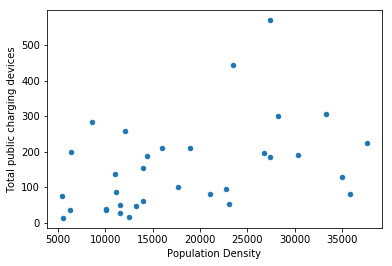

In [63]:
lon_bor_ev.plot.scatter('Population Density', 'Total public charging devices')

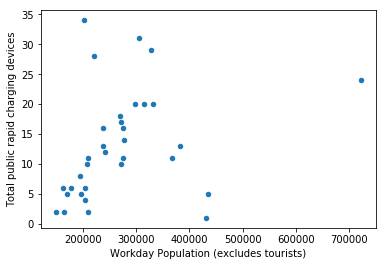

In [65]:
lon_bor_ev.plot.scatter('Workday Population (excludes tourists)', 'Total public rapid charging devices')

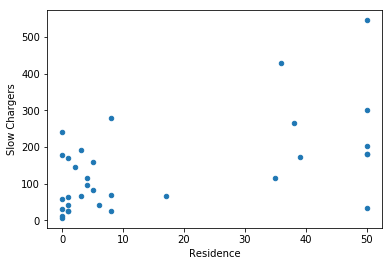

In [66]:
lon_bor_ev.plot.scatter('Residence', 'Slow Chargers')

## Clustering
Now that we have our feature table we will remove the borough name column, standardise the data so that they can be properly/equally compared and investigate the properties of our resultant clusters to answer the problem statement. We will also use the 'elbow' method to determine the optimal amount of clusters.

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium

In [45]:
lon_bor_cluster = lon_bor_ev.drop('Borough', axis = 1)
lon_bor_cluster.drop('latitude', axis = 1, inplace = True)
lon_bor_cluster.drop('longitude', axis = 1, inplace = True)
lon_bor_cluster.drop('Inner', axis = 1, inplace = True)
lon_bor_cluster.head()

,Area,Population,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
0,13.93,194352,60,2,28,164584,0.49,5,0.0,13952.045944,58
1,33.49,369088,137,20,35,331094,0.67,3,4.0,11020.842042,117
2,23.38,236687,34,8,14,194807,0.56,1,1.0,10123.481608,26
3,16.70,317264,209,16,63,274896,0.71,13,3.0,18997.844311,193
4,57.97,317899,75,10,23,271896,0.62,1,1.0,5483.853717,65


In [46]:
normalized_df=(lon_bor_cluster-lon_bor_cluster.min())/(lon_bor_cluster.max()-lon_bor_cluster.min())
normalized_df

,Area,Population,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
0,0.225330,0.512238,0.084381,0.030303,0.056235,0.025740,0.000820,0.081633,0.00,0.263899,0.094620
1,0.569393,0.989982,0.222621,0.575758,0.073350,0.317108,0.002461,0.040816,0.08,0.172552,0.204082
2,0.391557,0.627986,0.037702,0.212121,0.022005,0.078626,0.001458,0.000000,0.02,0.144587,0.035250
3,0.274055,0.848291,0.351885,0.454545,0.141809,0.218770,0.002826,0.244898,0.06,0.421144,0.345083
4,1.000000,0.850027,0.111311,0.272727,0.044010,0.213520,0.002005,0.000000,0.02,0.000000,0.107607
5,0.128056,0.608934,0.310592,0.121212,0.161369,0.497667,0.016133,1.000000,1.00,0.681348,0.322820
6,0.567986,1.000000,0.131059,0.575758,0.041565,0.288629,0.001823,0.020408,0.06,0.176792,0.109462
7,0.357432,0.917272,0.353680,0.909091,0.136919,0.272000,0.002370,0.285714,0.00,0.326927,0.319109
8,0.538610,0.857204,0.046679,0.393939,0.017115,0.223566,0.002005,0.000000,0.02,0.143806,0.033395
9,0.301847,0.702684,0.314183,0.818182,0.149144,0.123333,0.001367,0.142857,0.10,0.279181,0.283859


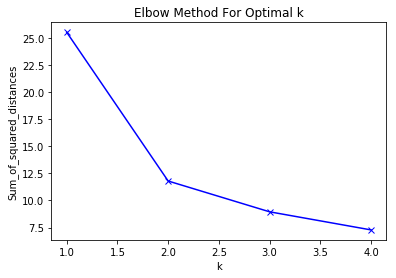

In [47]:
Sum_of_squared_distances = []
K = range(1,5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(normalized_df)
    Sum_of_squared_distances.append(km.inertia_)
    

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(normalized_df)

In [49]:
lon_bor_ev.insert(0, 'Cluster Labels', kmeans.labels_)
lon_bor_ev

,Cluster Labels,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
0,0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28,164584,0.49,5,0.0,13952.045944,58
1,0,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35,331094,0.67,3,4.0,11020.842042,117
2,0,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14,194807,0.56,1,1.0,10123.481608,26
3,0,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63,274896,0.71,13,3.0,18997.844311,193
4,0,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23,271896,0.62,1,1.0,5483.853717,65
5,1,Camden,1,8.40,229719,51.528999,-0.1255,186,5,71,434279,2.17,50,50.0,27347.500000,181
6,0,Croydon,0,33.41,372752,51.371399,-0.0977,86,20,22,314819,0.60,2,3.0,11156.899132,66
7,0,Ealing,0,21.44,342494,51.513000,-0.3089,210,31,61,305316,0.66,15,0.0,15974.533582,179
8,0,Enfield,0,31.74,320524,51.653801,-0.0799,39,14,12,277637,0.62,1,1.0,10098.424701,25
9,0,Greenwich,1,18.28,264008,51.489201,0.0648,188,28,66,220356,0.55,8,5.0,14442.450766,160


We can visualise the clusters and investigate the properties. 

In [50]:
latitude = 51.5074
longitude = -0.1278
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lon_bor_ev['latitude'], lon_bor_ev['longitude'], lon_bor_ev['Borough'], lon_bor_ev['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
lon_bor_ev.loc[lon_bor_ev['Cluster Labels'] == 0]

,Cluster Labels,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
0,0,Barking and Dagenham,0,13.93,194352,51.560699,0.1557,60,2,28,164584,0.49,5,0.0,13952.045944,58
1,0,Barnet,0,33.49,369088,51.625198,-0.1517,137,20,35,331094,0.67,3,4.0,11020.842042,117
2,0,Bexley,0,23.38,236687,51.454899,0.1505,34,8,14,194807,0.56,1,1.0,10123.481608,26
3,0,Brent,0,16.70,317264,51.558800,-0.2817,209,16,63,274896,0.71,13,3.0,18997.844311,193
4,0,Bromley,0,57.97,317899,51.403900,0.0198,75,10,23,271896,0.62,1,1.0,5483.853717,65
6,0,Croydon,0,33.41,372752,51.371399,-0.0977,86,20,22,314819,0.60,2,3.0,11156.899132,66
7,0,Ealing,0,21.44,342494,51.513000,-0.3089,210,31,61,305316,0.66,15,0.0,15974.533582,179
8,0,Enfield,0,31.74,320524,51.653801,-0.0799,39,14,12,277637,0.62,1,1.0,10098.424701,25
9,0,Greenwich,1,18.28,264008,51.489201,0.0648,188,28,66,220356,0.55,8,5.0,14442.450766,160
12,0,Haringey,0,11.42,263386,51.599998,-0.1119,52,11,19,209884,0.48,9,6.0,23063.572680,41


In [52]:
lon_bor_ev.loc[lon_bor_ev['Cluster Labels'] == 1]

,Cluster Labels,Borough,Inner,Area,Population,latitude,longitude,Total public charging devices,Total public rapid charging devices,"Charging devices per 100,000 population",Workday Population (excludes tourists),Job Density,Parking,Residence,Population Density,Slow Chargers
5,1,Camden,1,8.40,229719,51.528999,-0.1255,186,5,71,434279,2.17,50,50.0,27347.500000,181
10,1,Hackney,1,7.36,257379,51.544998,-0.0553,128,12,46,240792,0.76,50,35.0,34969.972826,116
11,1,Hammersmith and Fulham,1,6.33,178685,51.492699,-0.2339,301,34,162,202214,1.18,50,38.0,28228.278041,267
17,1,Islington,1,5.74,215667,51.541599,-0.1022,224,20,94,297460,1.42,50,50.0,37572.648084,204
18,1,Kensington and Chelsea,1,4.68,155594,51.501999,-0.1947,306,5,196,196892,1.55,50,50.0,33246.581197,301
20,1,Lambeth,1,10.36,314242,51.460701,-0.1163,191,18,59,269981,0.75,50,39.0,30332.239382,173
26,1,Southwark,1,11.14,298464,51.503502,-0.0804,195,13,61,382582,1.42,50,50.0,26792.100539,182
28,1,Tower Hamlets,1,7.63,272890,51.509899,-0.0059,79,11,25,367677,1.43,28,17.0,35765.399738,68
30,1,Wandsworth,1,13.23,310516,51.456699,-0.1910,443,13,136,238102,0.62,50,36.0,23470.597128,430
31,1,Westminster,1,8.29,226841,51.497299,-0.1372,570,24,223,721351,4.28,50,50.0,27363.208685,546


In [53]:
import seaborn as sns

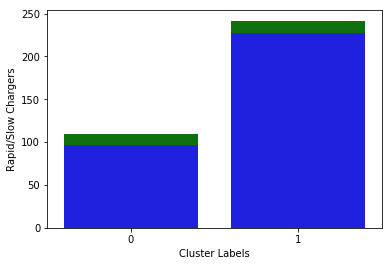

In [54]:
sns.barplot(y = 'Total public charging devices', x = 'Cluster Labels', data = lon_bor_ev, color = 'green', ci = None)
bottom_plot = sns.barplot(y = 'Slow Chargers', x = 'Cluster Labels', data = lon_bor_ev, color = 'blue', ci = None)
plt.ylabel('Rapid/Slow Chargers')
plt.show()

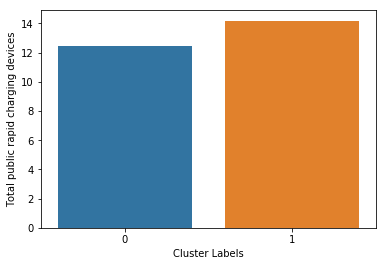

In [56]:
sns.barplot(y = 'Total public rapid charging devices', x = 'Cluster Labels', data = lon_bor_ev, ci = None)

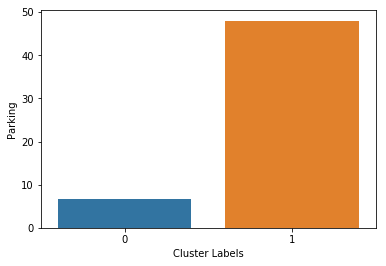

In [57]:
sns.barplot(y = 'Parking', x = 'Cluster Labels', data = lon_bor_ev , ci = None)

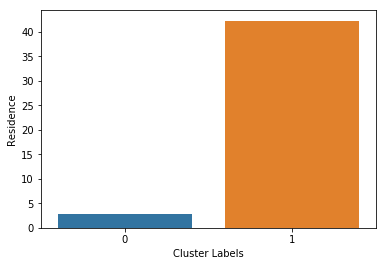

In [58]:
sns.barplot(y = 'Residence', x = 'Cluster Labels', data = lon_bor_ev , ci = None)

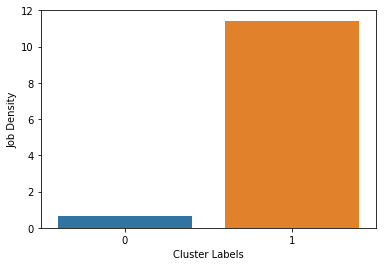

In [59]:
sns.barplot(y = 'Job Density', x = 'Cluster Labels', data = lon_bor_ev , ci = None)

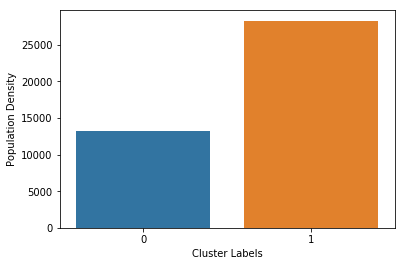

In [60]:
sns.barplot(y = 'Population Density', x = 'Cluster Labels', data = lon_bor_ev , ci = None)

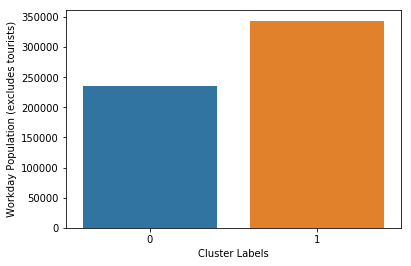

In [61]:
sns.barplot(y = 'Workday Population (excludes tourists)', x = 'Cluster Labels', data = lon_bor_ev , ci = None)

## Conclusion
We see that cluster 1 is more denseley populated with higher amounts of both workday and resident populations and also significantly more parking. The data shows that proportionally the amount of chargers avalaible matches this disparity ie there are more chargers avaialable in cluster 1. However is it clear that much more of both types of chargers may need to be installed in cluster 1 since it has large number of residential and work populations. While for cluster 0 while it is less densely populated its work day population relative to its proportion of residences may mean that more rapid chargers are needed to charge electric vehicles during working hours. 